Data Mining - Final Term Project(ss5383)

In [1]:
# TensorFlow Installation
#pip install tensorflow==2.18.0

In [ ]:
!pip show tensorflow

In [3]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, brier_score_loss, 
    accuracy_score, roc_curve, auc
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings("ignore")



In [4]:
# Load Dataset from GitHub
dataset_url ="https://github.com/ss5383/Singireddy_Siddharth_Reddy_finalproject/blob/main/Heart_Disease_Dataset.csv"
try:
    df = pd.read_csv(dataset_url)
    if df.empty:
        print("Dataset is empty.")
    else:
        print(f"Dataset successfully loaded with shape: {df.shape}")
except FileNotFoundError:
    print("File not found. Verify the URL or path.")
except pd.errors.EmptyDataError:
    print("File exists but contains no data.")
except Exception as error:
    print(f"An error occurred: {error}")

print("\nDataset Information:")
print(df.info())

# Check for Null Values
print("\nMissing Values Check:")
print(df.isnull().sum())

# Preview the Dataset
print("\nInitial Dataset Snapshot:")
print(df.head())



Dataset successfully loaded with shape: (918, 12)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

Missing Values Check:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
Fa

In [5]:
# Identify and Encode Categorical Columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
print("\nUnique values in Categorical Columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

print("\nDataset after Label Encoding:")
print(df.head())




Unique values in Categorical Columns:
Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
RestingECG: ['Normal' 'ST' 'LVH']
ExerciseAngina: ['N' 'Y']
ST_Slope: ['Up' 'Flat' 'Down']

Dataset after Label Encoding:
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              0        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5         1             1  
4    122             

In [6]:
# Feature and Label Separation
X = df.iloc[:, :-1]
y = df.iloc[:, -1]



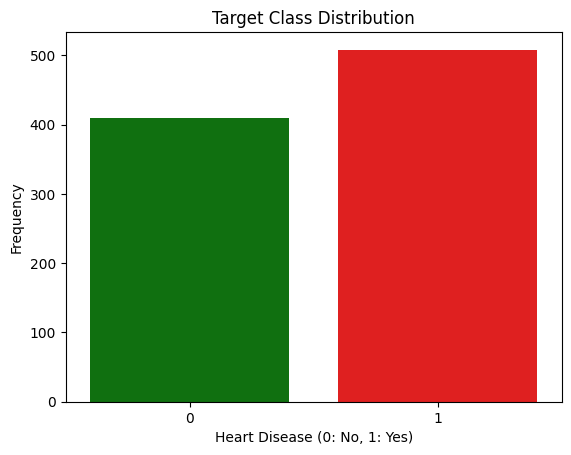

In [7]:
# Target Distribution Visualization
sns.countplot(x=y, palette=["green", "red"])
plt.xlabel("Heart Disease (0: No, 1: Yes)")
plt.ylabel("Frequency")
plt.title("Target Class Distribution")
plt.show()



In [8]:
# Display Distribution Percentages
pos, neg = y.value_counts()
total = y.count()
print(f"\n{(neg/total)*100:.2f}% instances are 'No Heart Disease' ({neg})")
print(f"{(pos/total)*100:.2f}% instances are 'Yes Heart Disease' ({pos})")




44.66% instances are 'No Heart Disease' (410)
55.34% instances are 'Yes Heart Disease' (508)


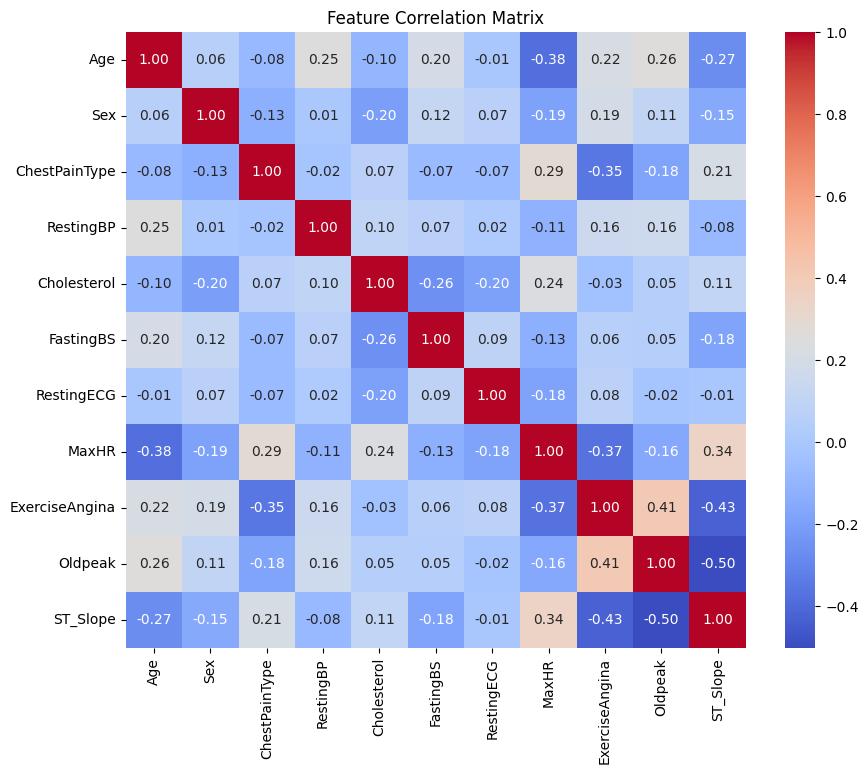

In [9]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation = X.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()



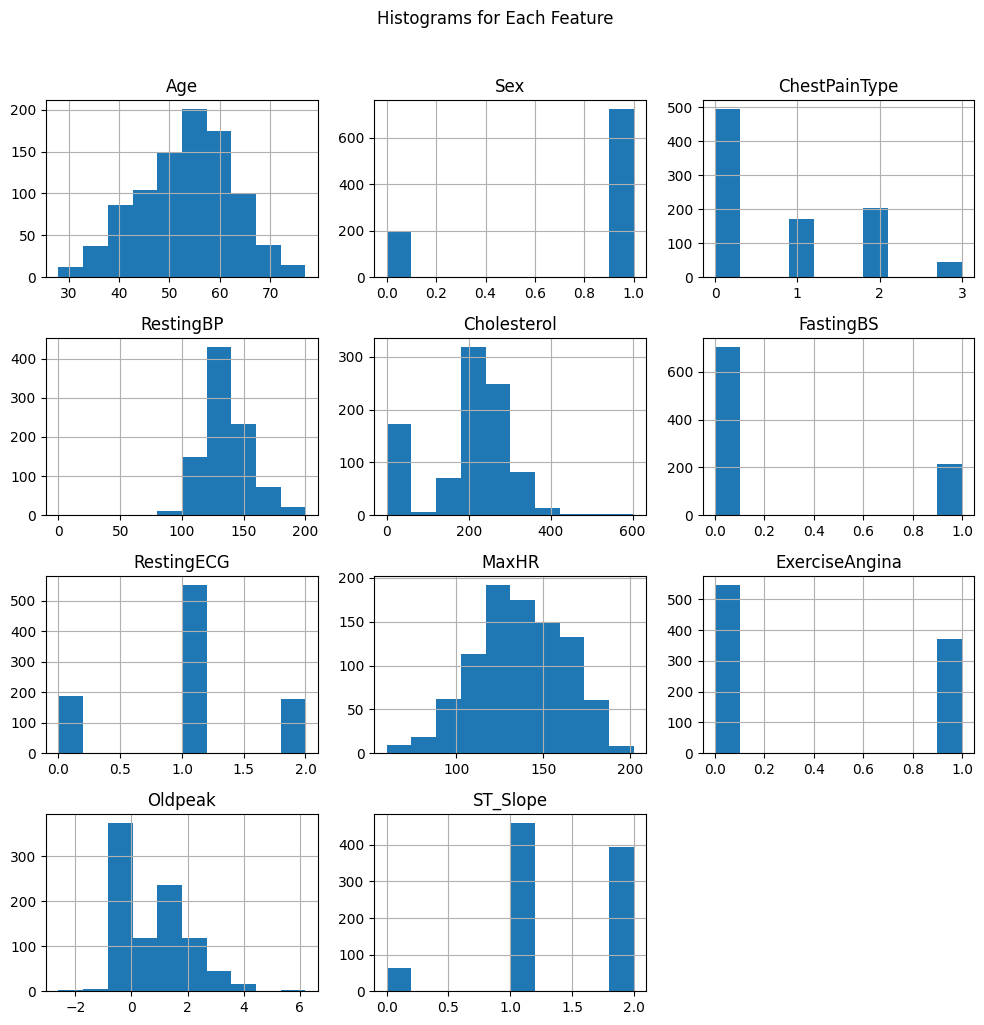

In [10]:
# Histograms
X.hist(figsize=(10, 10))
plt.suptitle("Histograms for Each Feature", y=1.02)
plt.tight_layout()
plt.show()



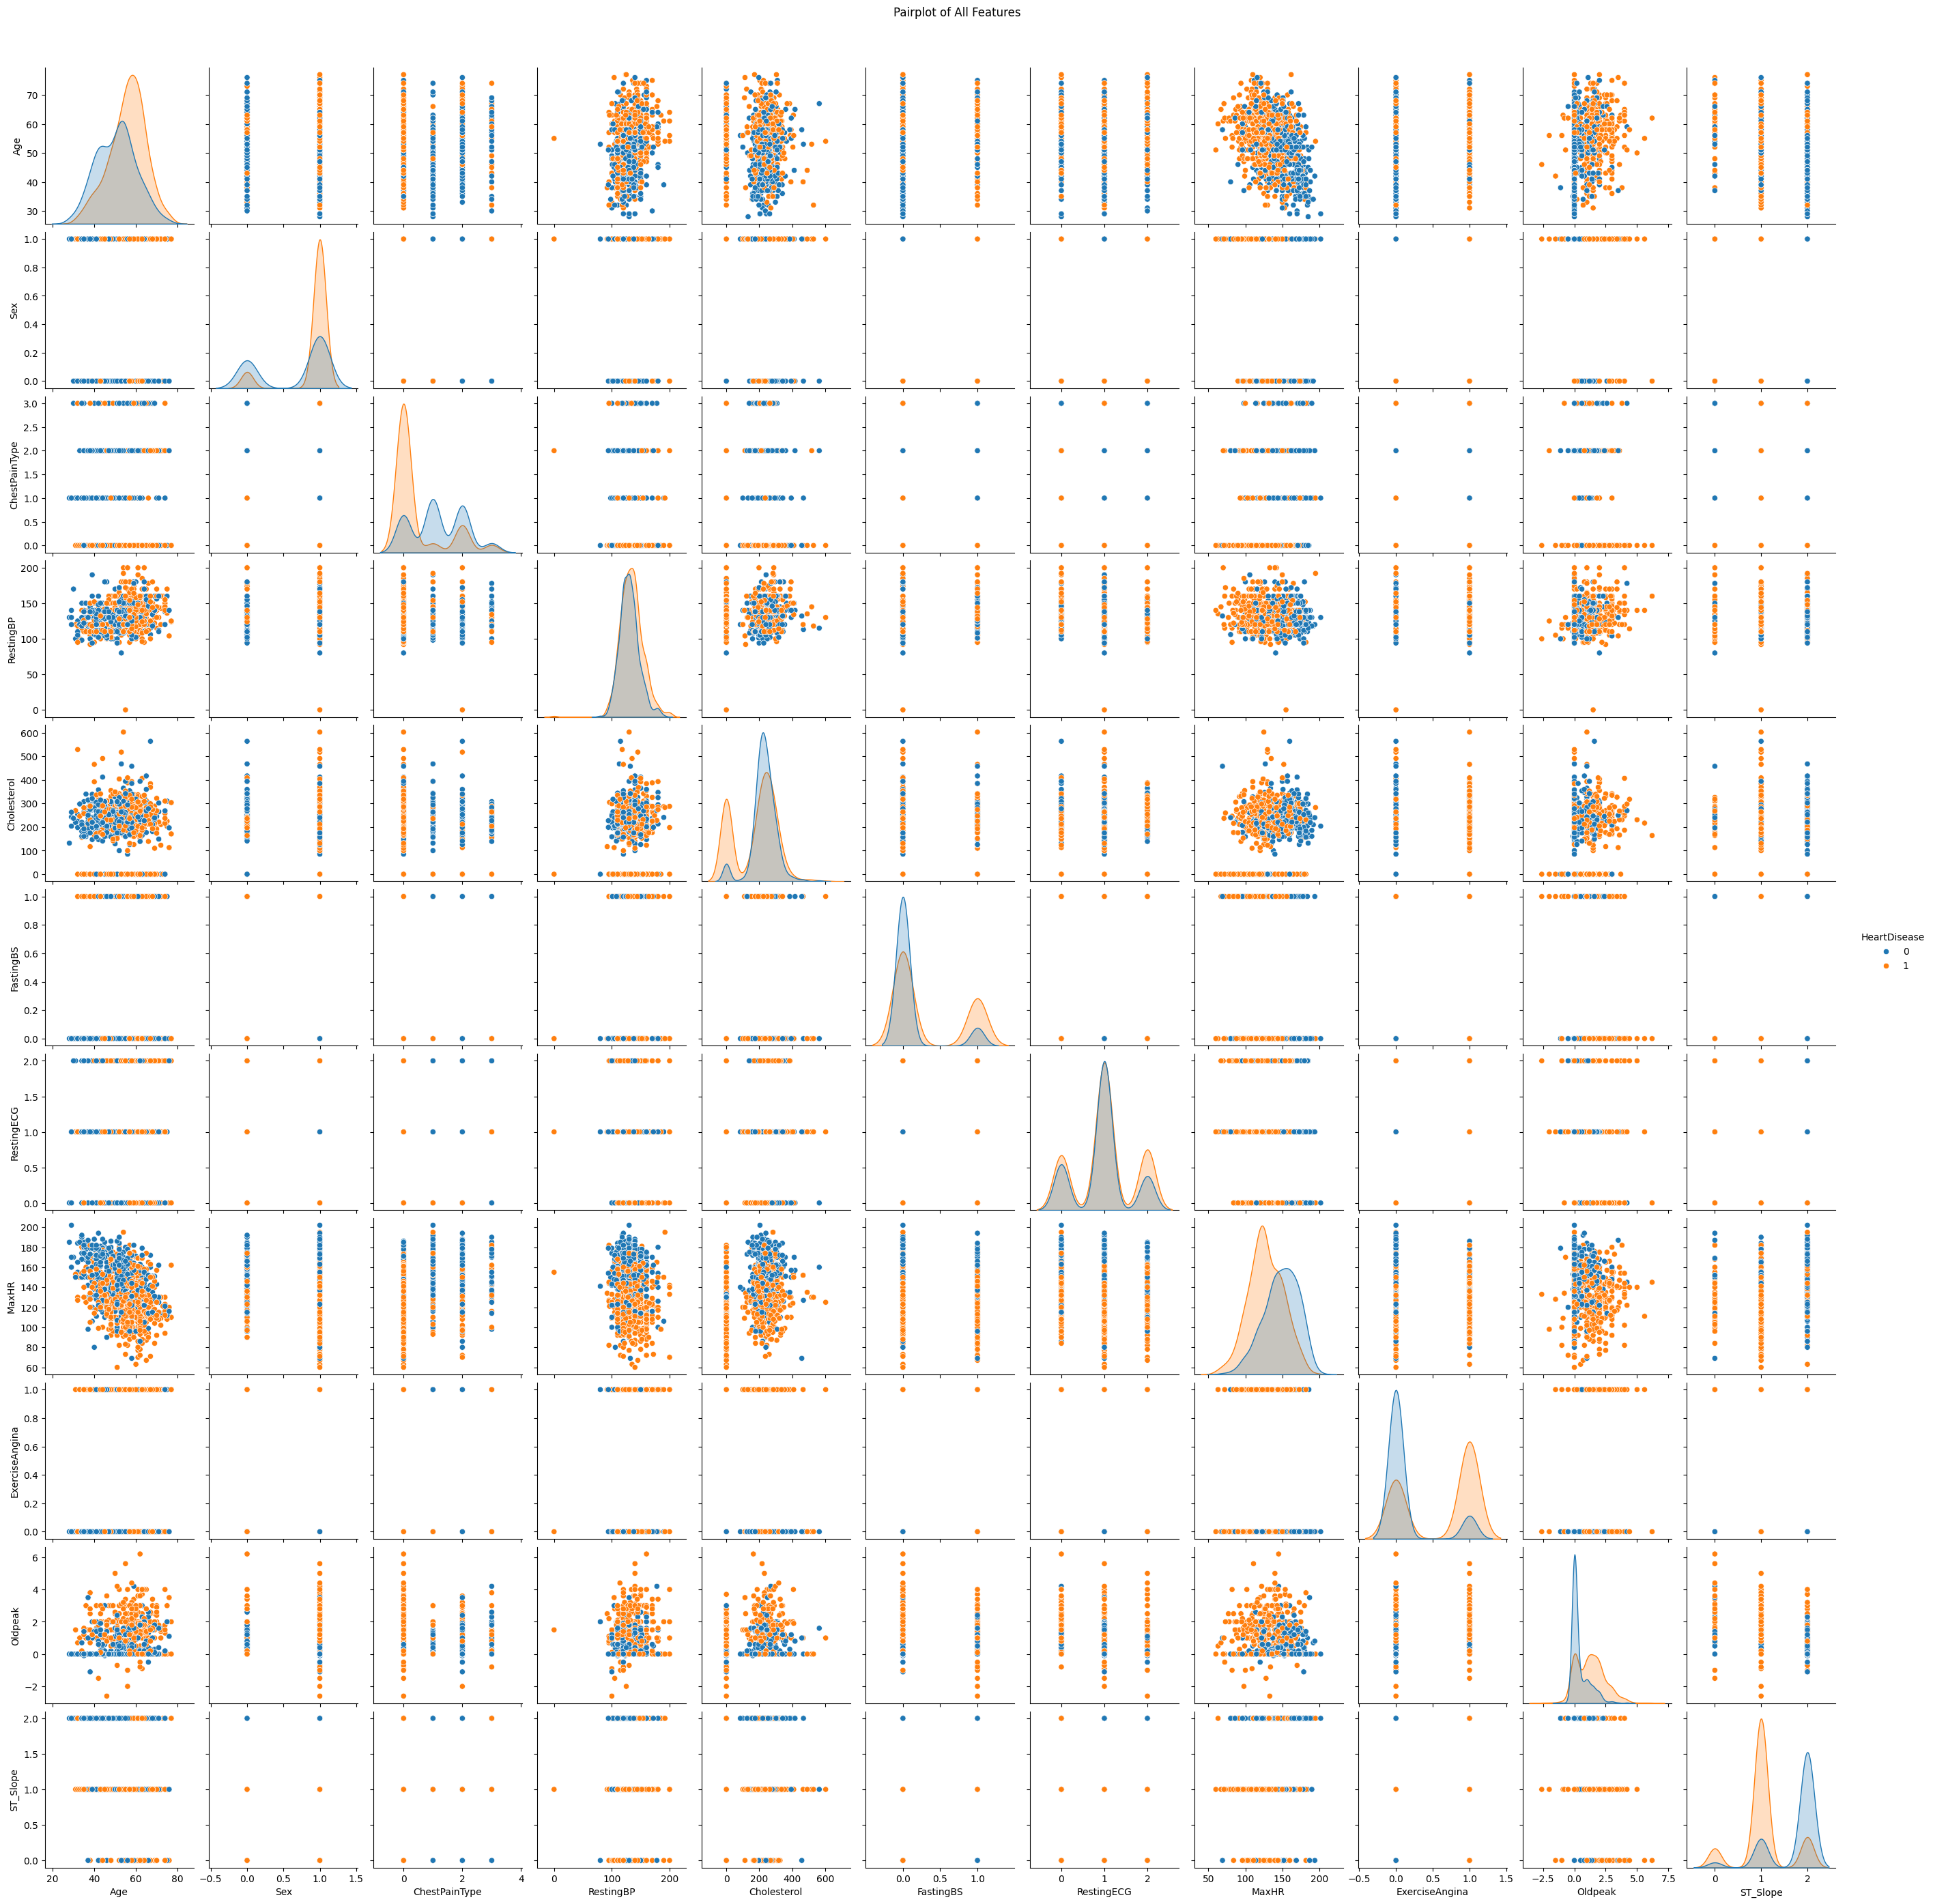

In [11]:
# Pairwise Relationships
sns.pairplot(df, hue="HeartDisease")
plt.suptitle("Pairplot of All Features", y=1.02)
plt.show()



In [12]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [13]:
# Data Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [14]:
# Reshape for LSTM Input
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [15]:
# Utility: Confusion Matrix Plotting
def visualize_conf_matrix(matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

In [16]:
# Utility: ROC-AUC Curve Plotting
def draw_roc_auc(model_name, fpr, tpr, auc_score):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="blue")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC AUC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [17]:
# Metrics Calculator
def evaluate_model(name, y_train_fold, y_test_fold, y_pred, y_prob):
    tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred).ravel()

    print(f"\nConfusion Matrix ({name}):\n", confusion_matrix(y_test_fold, y_pred))
    visualize_conf_matrix(confusion_matrix(y_test_fold, y_pred), name)

    try:
        fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
        auc_val = auc(fpr, tpr)
        draw_roc_auc(name, fpr, tpr, auc_val)
    except:
        print("ROC curve could not be plotted due to insufficient class variance.")

    # Calculate Metrics
    metrics = {
        "True Positive (TP)": tp,
        "True Negative (TN)": tn,
        "False Positive (FP)": fp,
        "False Negative (FN)": fn,
        "Sensitivity (TPR)": tp / (tp + fn) if (tp + fn) else 0,
        "Specificity (TNR)": tn / (tn + fp) if (tn + fp) else 0,
        "False Positive Rate (FPR)": fp / (fp + tn) if (fp + tn) else 0,
        "False Negative Rate (FNR)": fn / (fn + tp) if (fn + tp) else 0,
        "Recall (r)": tp / (tp + fn) if (tp + fn) else 0,
        "Precision (P)": tp / (tp + fp) if (tp + fp) else 0,
        "F1 Measure (F1)": (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0,
        "Accuracy": (tp + tn) / (tp + tn + fp + fn),
        "Error Rate": (fp + fn) / (tp + tn + fp + fn),
        "Balanced Accuracy": ((tp / (tp + fn)) + (tn / (tn + fp))) / 2 if (tp + fn and tn + fp) else 0,
        "True Skill Statistics (TSS)": (tp / (tp + fn)) - (fp / (fp + tn)) if (tp + fn and fp + tn) else 0,
        "Heidke Skill Score (HSS)": (2 * ((tp * tn) - (fp * fn))) / (((tp + fn) * (fn + tn)) + ((tp + fp) * (fp + tn))) if (((tp + fn)*(fn + tn) + (tp + fp)*(fp + tn)) > 0) else 0,
        "ROC_AUC Score": roc_auc_score(y_test_fold, y_prob),
        "Brier Score": brier_score_loss(y_test_fold, y_prob)
    }

    # Brier Skill Score
    baseline_prob = [y_train_fold.mean()] * len(y_test_fold)
    baseline_brier = brier_score_loss(y_test_fold, baseline_prob)
    metrics["Brier Skill Score"] = 1 - (metrics["Brier Score"] / baseline_brier) if baseline_brier else 0

    return metrics

In [18]:
# Random Forest Model Function
def run_random_forest(name, results, X_train_fold, y_train_fold, X_test_fold, y_test_fold):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_fold, y_train_fold)
    predictions = model.predict(X_test_fold)
    prob_scores = model.predict_proba(X_test_fold)[:, 1]
    results.append(evaluate_model(name, y_train_fold, y_test_fold, predictions, prob_scores))
    return results

In [19]:
# K-Nearest Neighbors Function
def run_knn(name, results, X_train_fold, y_train_fold, X_test_fold, y_test_fold):
    model = KNeighborsClassifier(n_neighbors=7)
    model.fit(X_train_fold, y_train_fold)
    predictions = model.predict(X_test_fold)
    prob_scores = model.predict_proba(X_test_fold)[:, 1]
    results.append(evaluate_model(name, y_train_fold, y_test_fold, predictions, prob_scores))
    return results

In [20]:
# LSTM Model Function
def run_lstm(name, results, X_train_lstm, y_train_fold, X_test_lstm, y_test_fold):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_lstm, y_train_fold, epochs=10, batch_size=16, verbose=0)

    predictions = (model.predict(X_test_lstm) > 0.5).astype("int32")
    prob_scores = model.predict(X_test_lstm).flatten()
    results.append(evaluate_model(name, y_train_fold, y_test_fold, predictions, prob_scores))
    return results

In [21]:
# Lists to hold metrics for each fold
rf_train_metrics, knn_train_metrics, lstm_train_metrics = [], [], []
fold_labels = []


Running Fold 1

Confusion Matrix (Random_Forest):
 [[30  4]
 [ 7 33]]


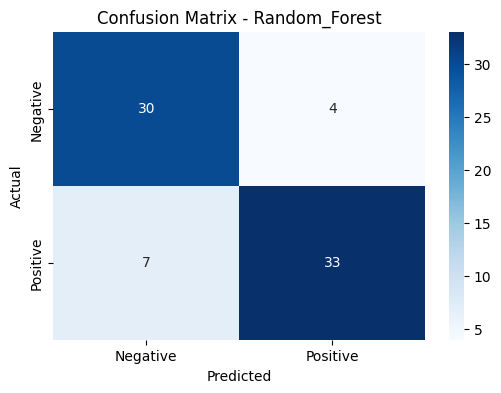

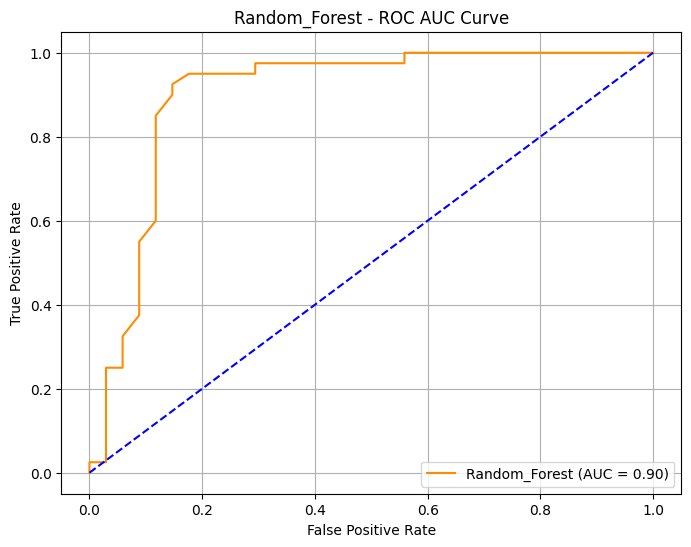


Confusion Matrix (K_Nearest_Neighbor):
 [[29  5]
 [ 4 36]]


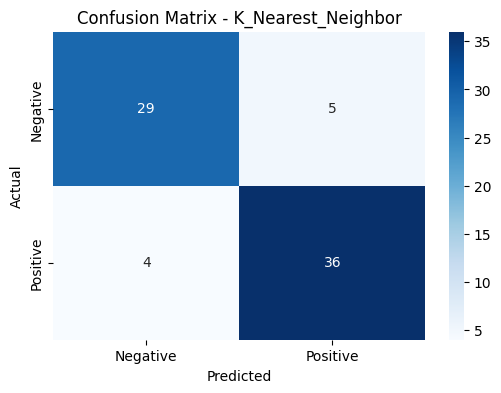

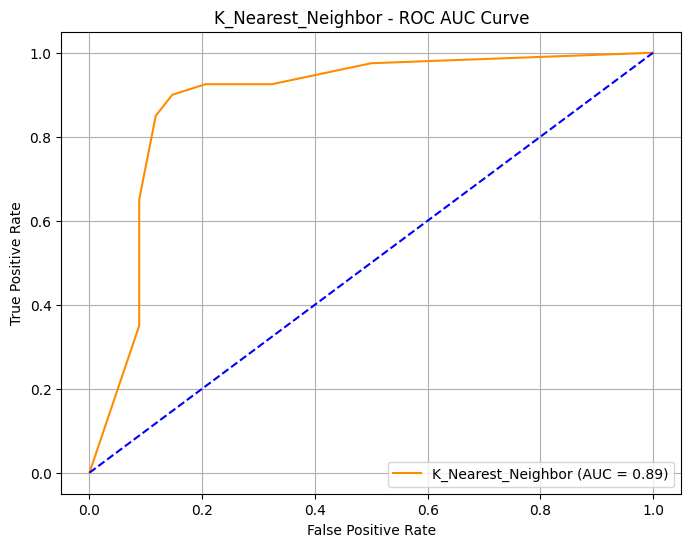

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Confusion Matrix (LSTM):
 [[29  5]
 [15 25]]


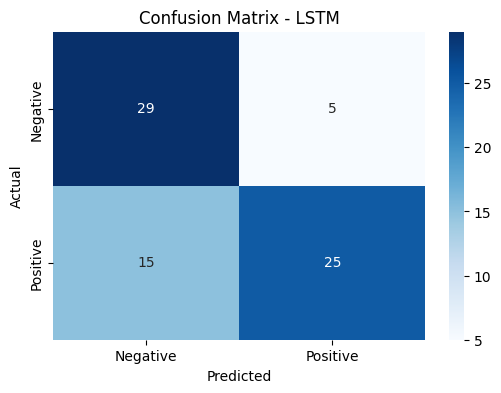

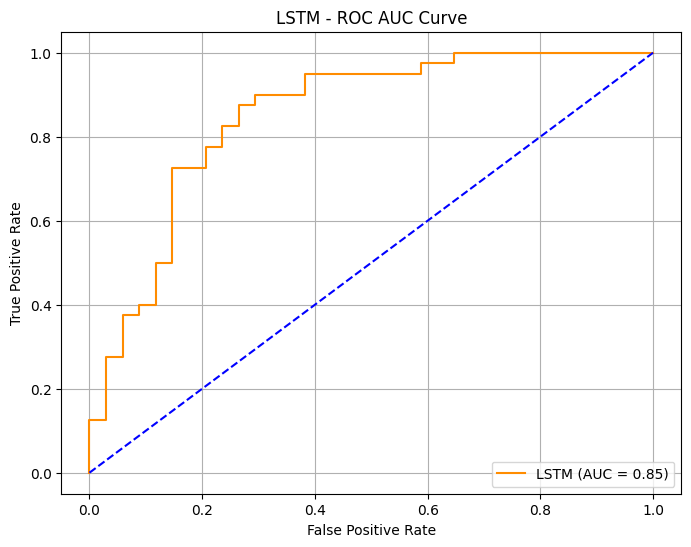


Running Fold 2

Confusion Matrix (Random_Forest):
 [[29  5]
 [ 2 38]]


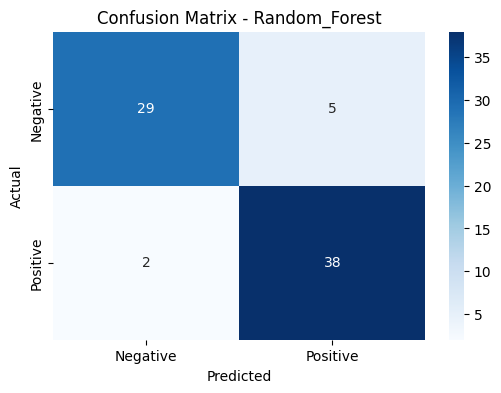

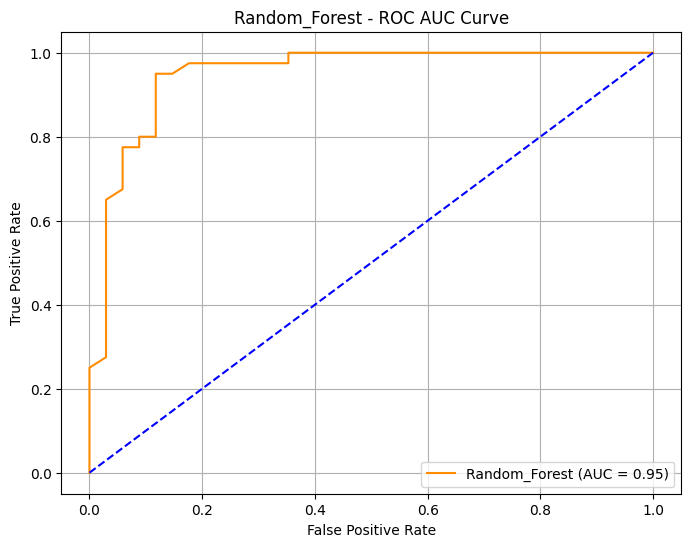


Confusion Matrix (K_Nearest_Neighbor):
 [[27  7]
 [ 1 39]]


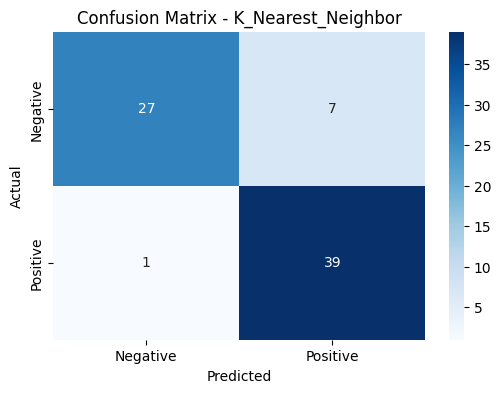

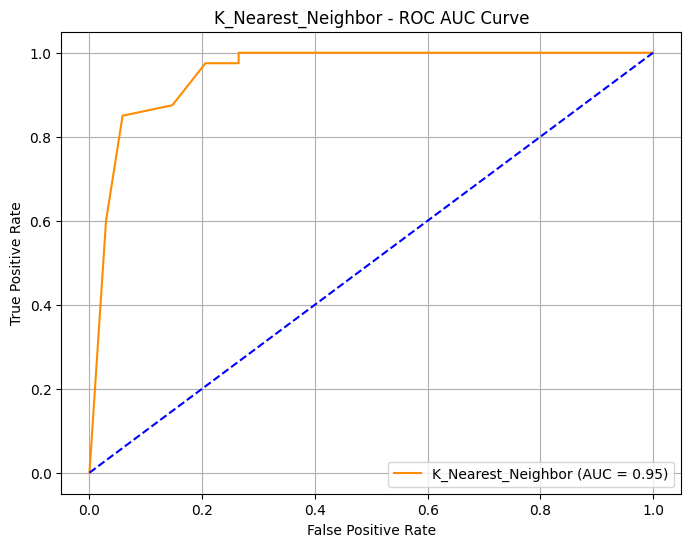

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Confusion Matrix (LSTM):
 [[26  8]
 [ 6 34]]


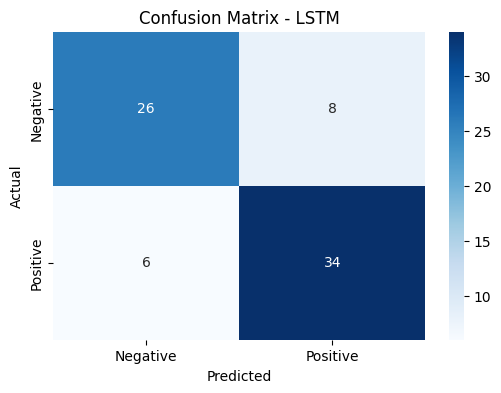

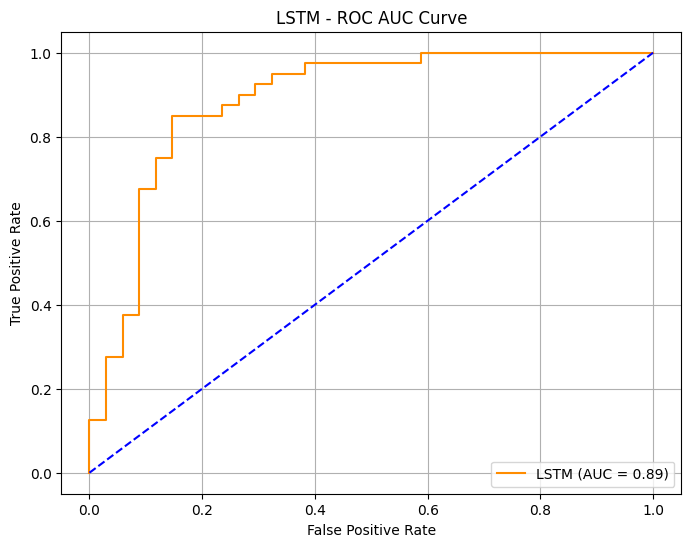


Running Fold 3

Confusion Matrix (Random_Forest):
 [[29  5]
 [ 6 34]]


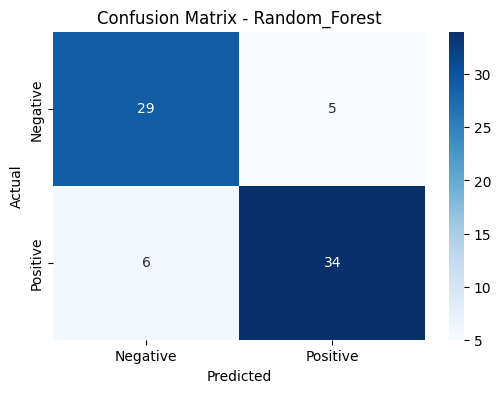

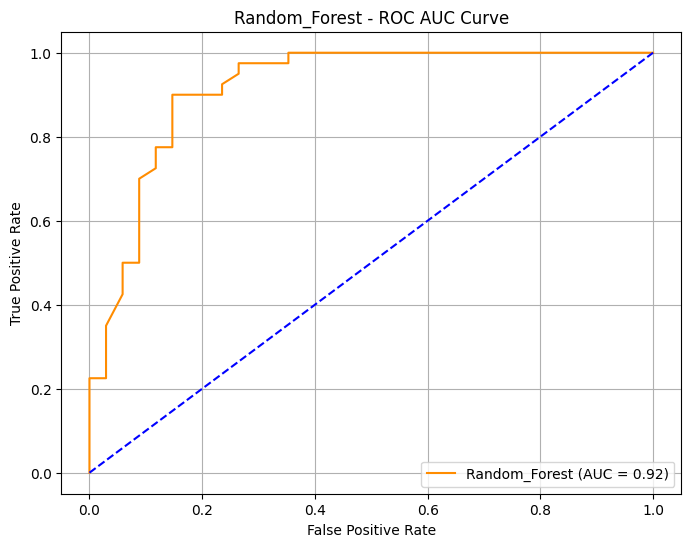


Confusion Matrix (K_Nearest_Neighbor):
 [[29  5]
 [ 6 34]]


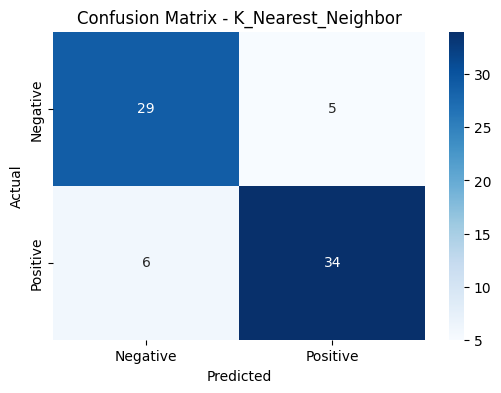

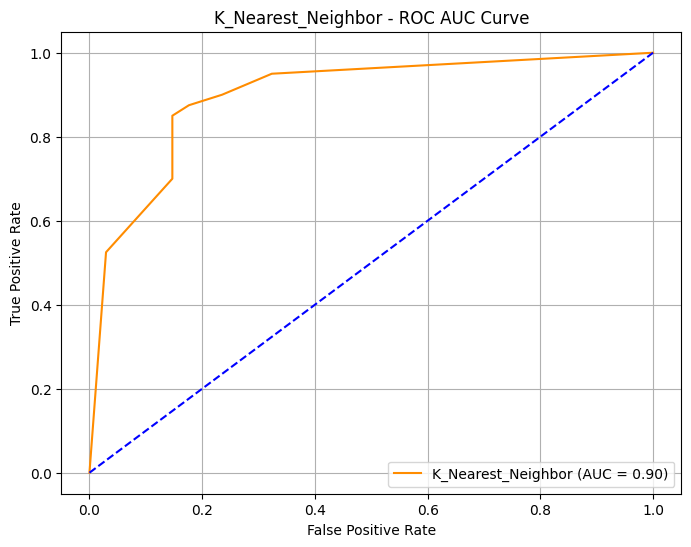

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000017634ED5620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Confusion Matrix (LSTM):
 [[ 9 25]
 [ 0 40]]


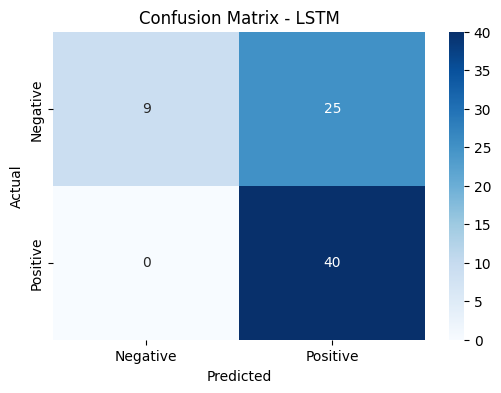

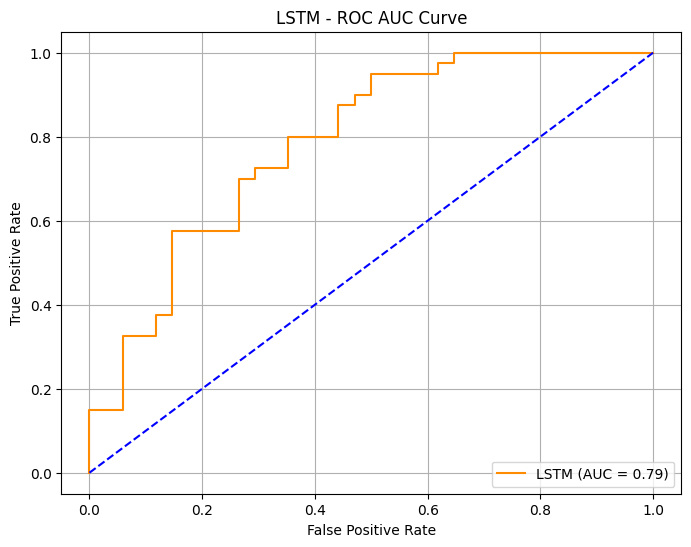


Running Fold 4

Confusion Matrix (Random_Forest):
 [[24  9]
 [ 5 36]]


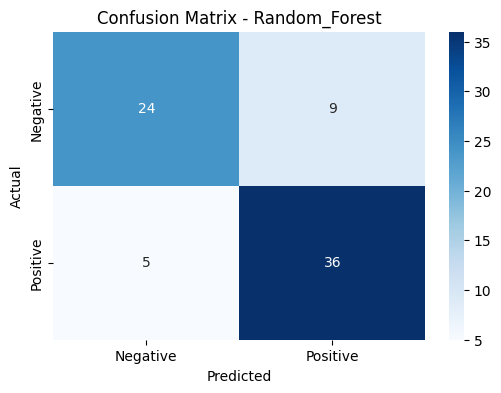

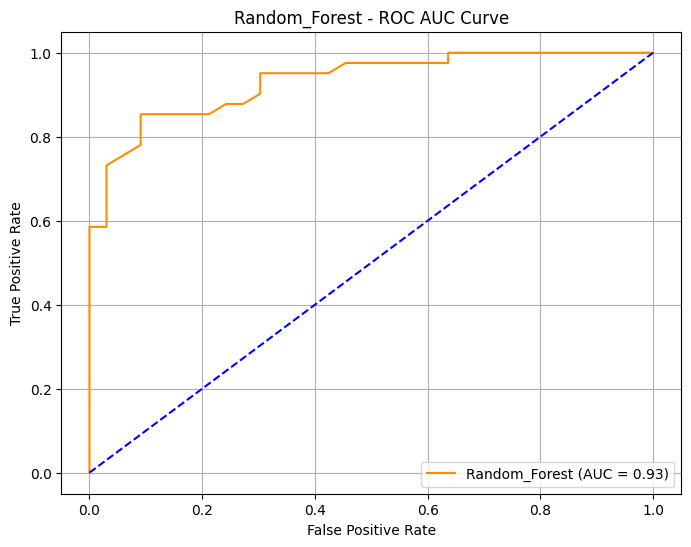


Confusion Matrix (K_Nearest_Neighbor):
 [[24  9]
 [ 4 37]]


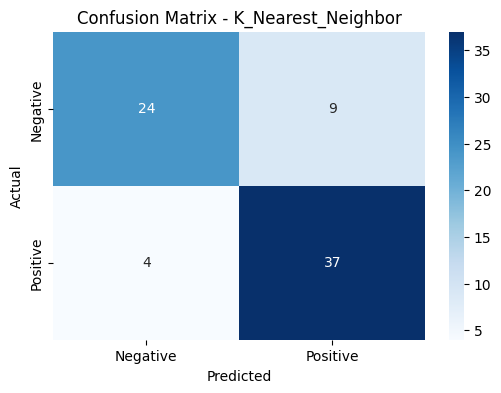

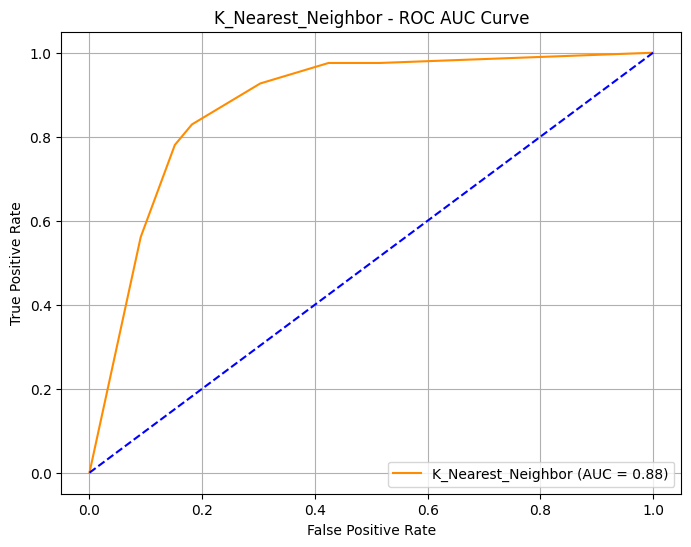

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000017631B73420> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Confusion Matrix (LSTM):
 [[26  7]
 [ 8 33]]


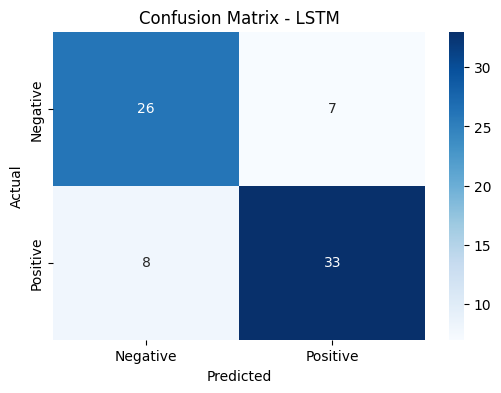

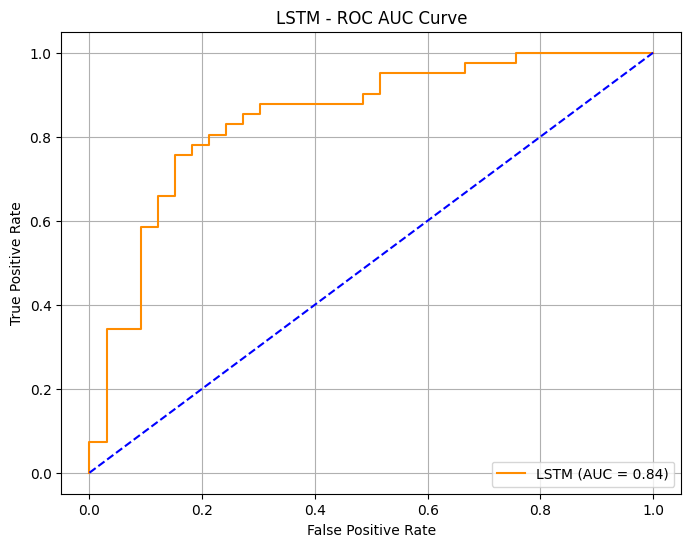


Running Fold 5

Confusion Matrix (Random_Forest):
 [[28  5]
 [ 5 35]]


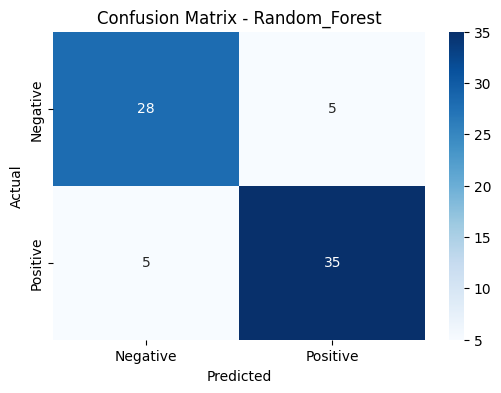

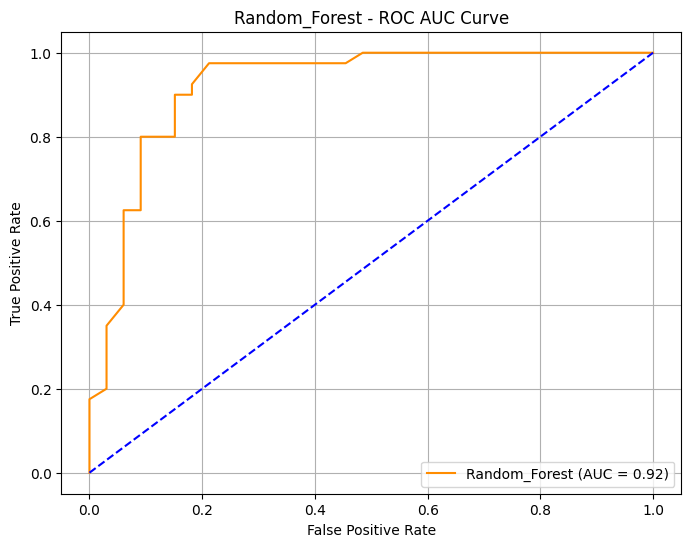


Confusion Matrix (K_Nearest_Neighbor):
 [[27  6]
 [ 4 36]]


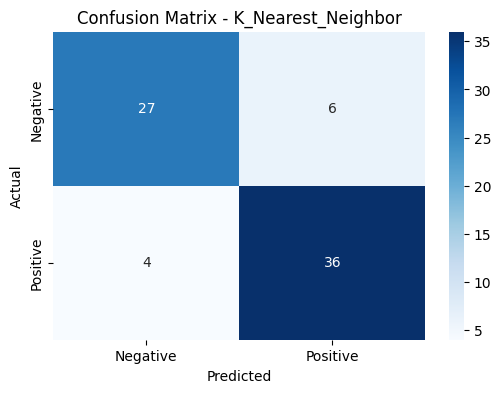

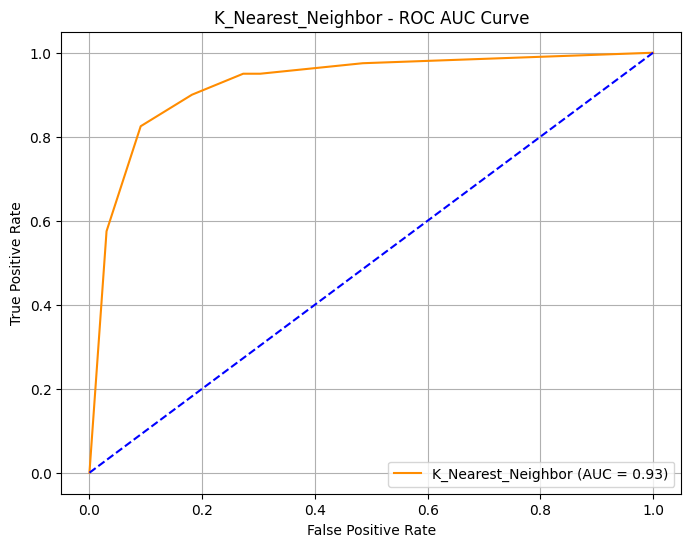

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Confusion Matrix (LSTM):
 [[23 10]
 [ 5 35]]


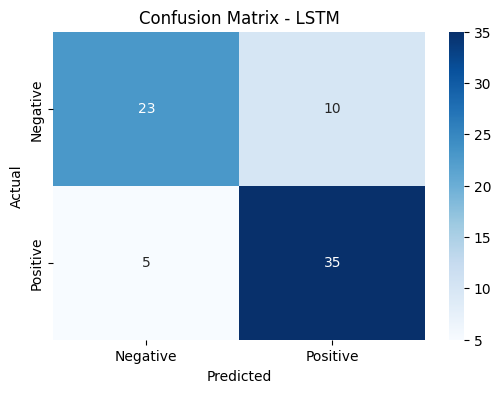

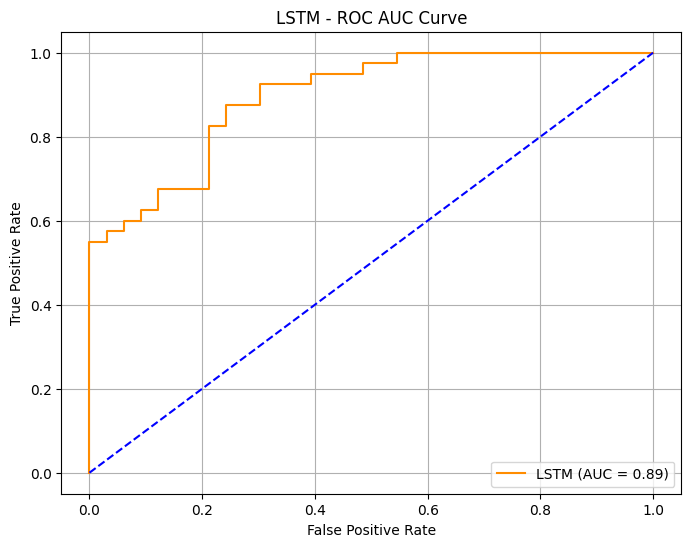


Running Fold 6

Confusion Matrix (Random_Forest):
 [[25  8]
 [ 8 32]]


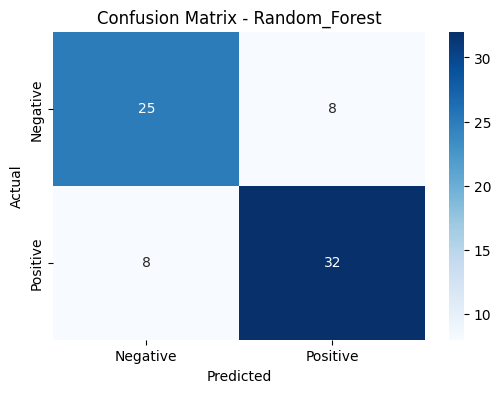

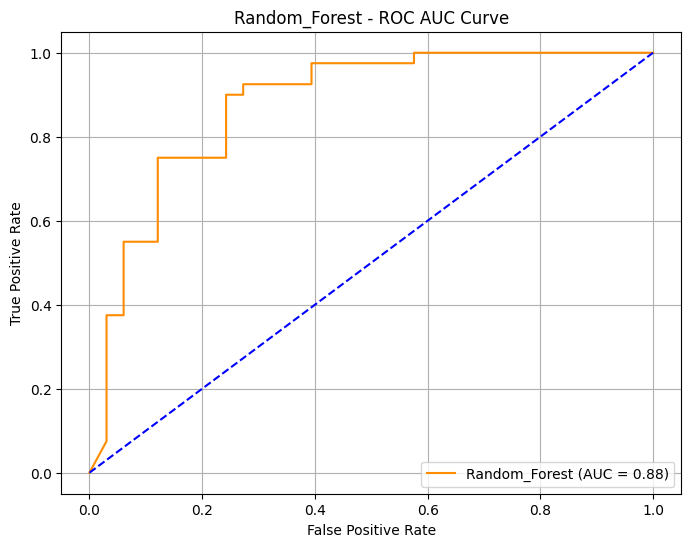


Confusion Matrix (K_Nearest_Neighbor):
 [[28  5]
 [ 6 34]]


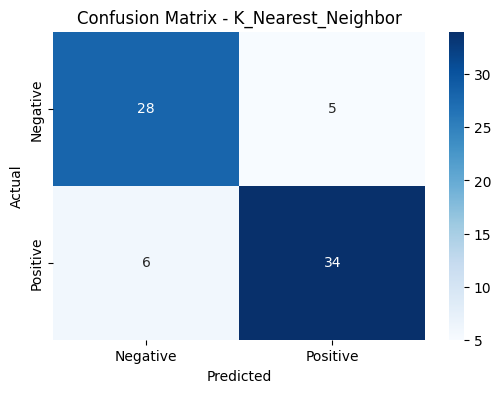

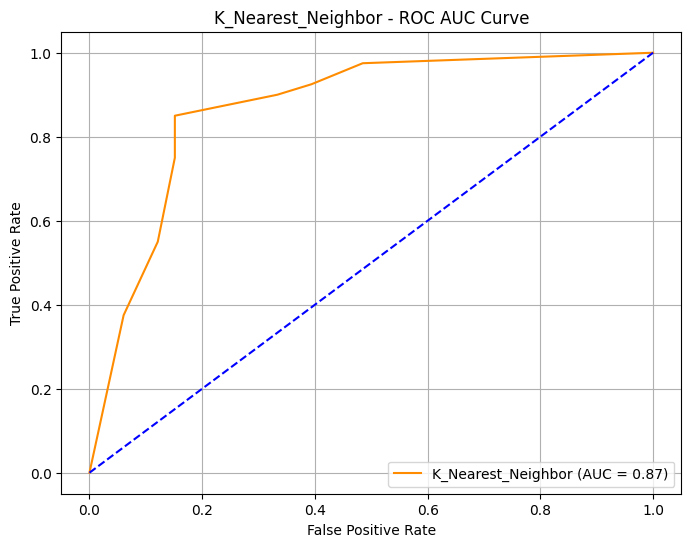

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Confusion Matrix (LSTM):
 [[22 11]
 [ 5 35]]


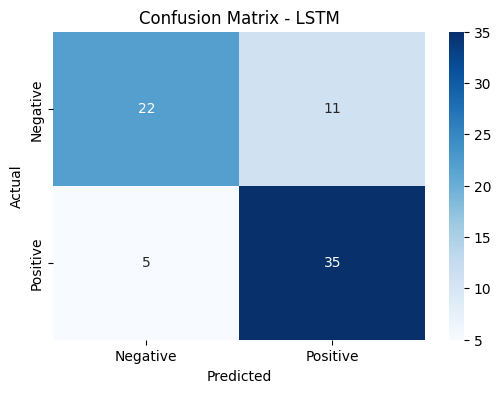

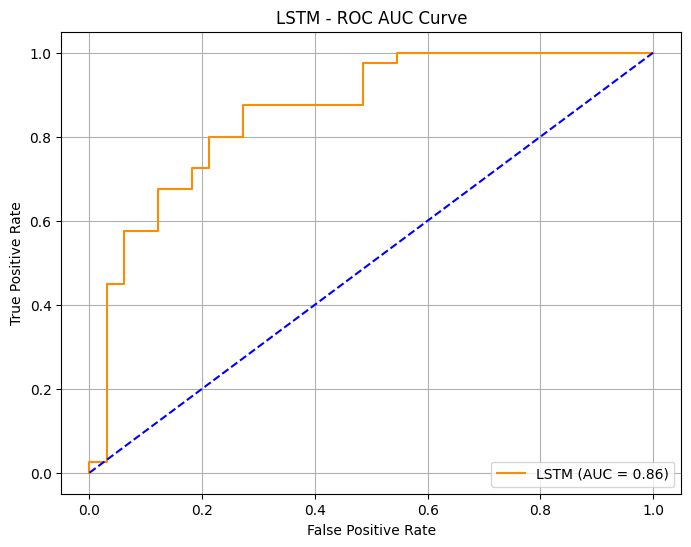


Running Fold 7

Confusion Matrix (Random_Forest):
 [[28  5]
 [ 4 36]]


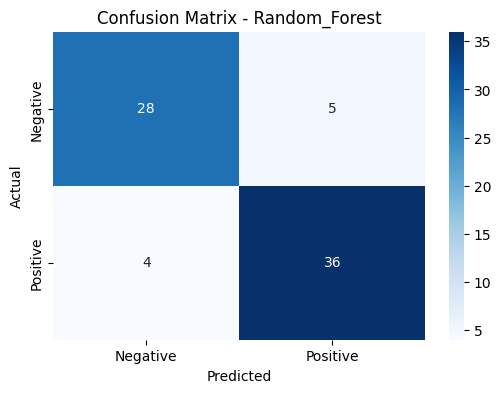

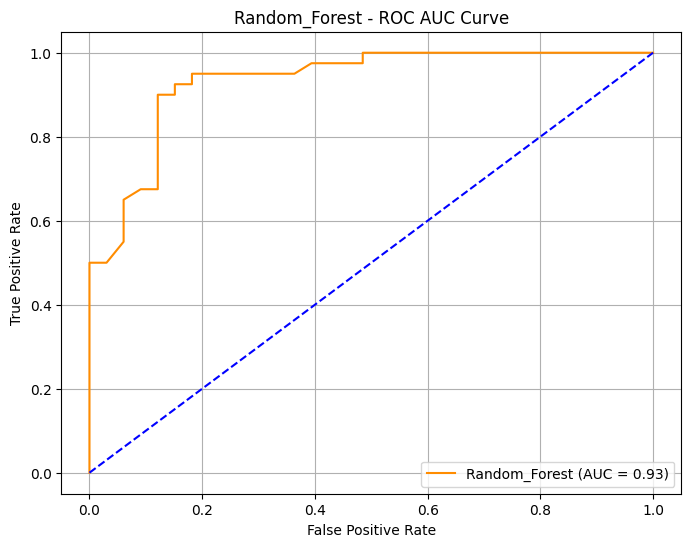


Confusion Matrix (K_Nearest_Neighbor):
 [[29  4]
 [ 3 37]]


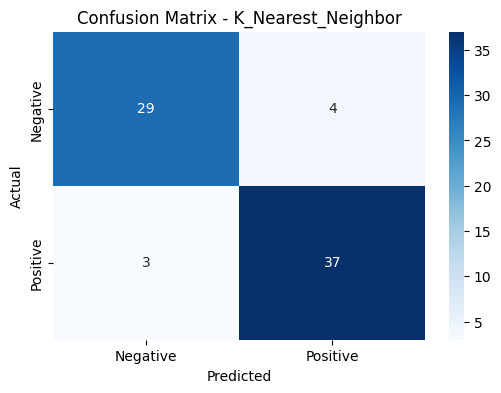

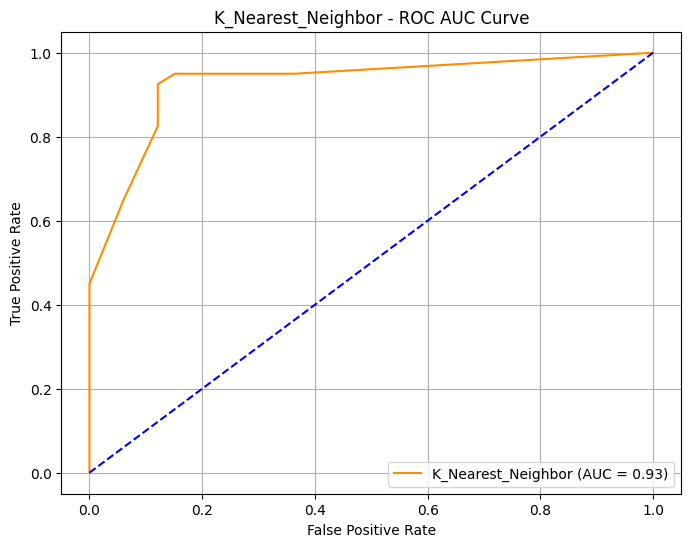

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Confusion Matrix (LSTM):
 [[31  2]
 [16 24]]


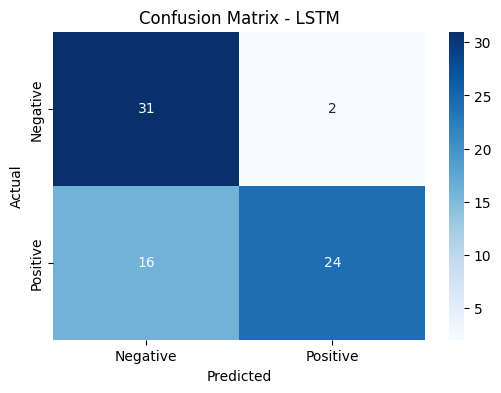

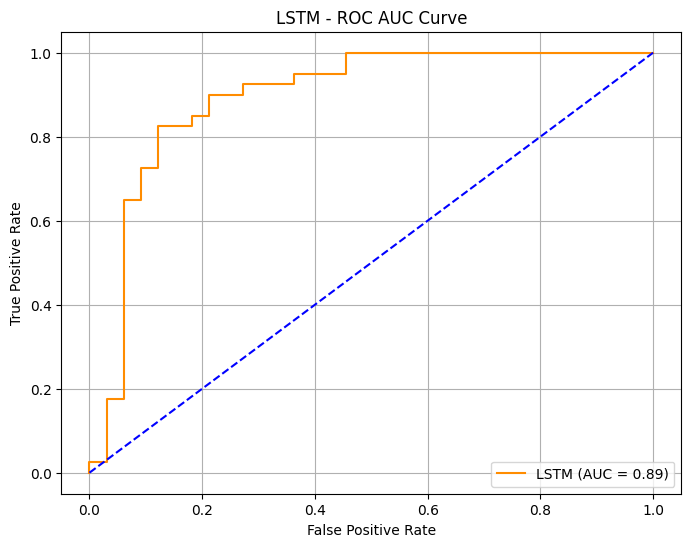


Running Fold 8

Confusion Matrix (Random_Forest):
 [[29  4]
 [ 2 38]]


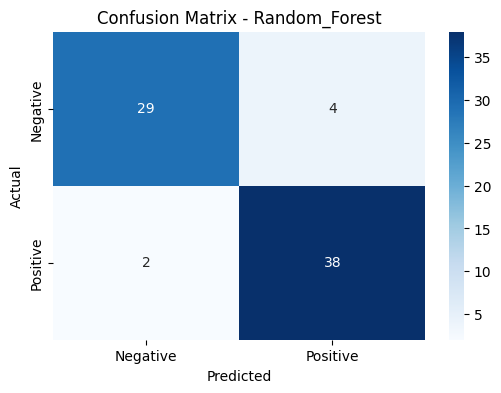

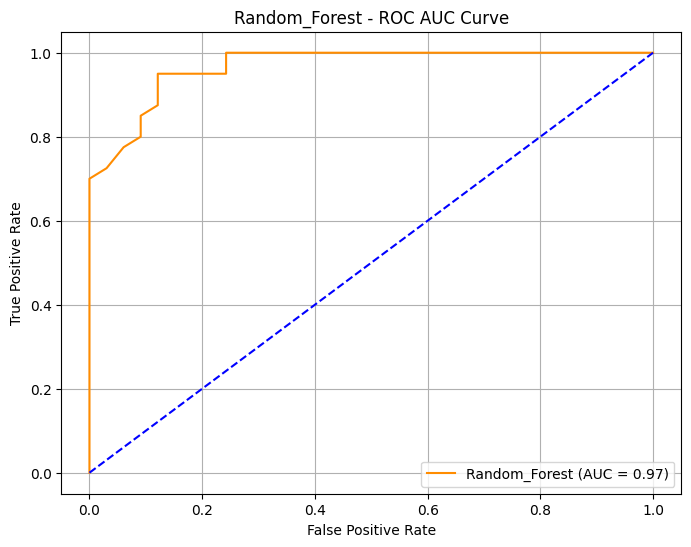


Confusion Matrix (K_Nearest_Neighbor):
 [[26  7]
 [ 6 34]]


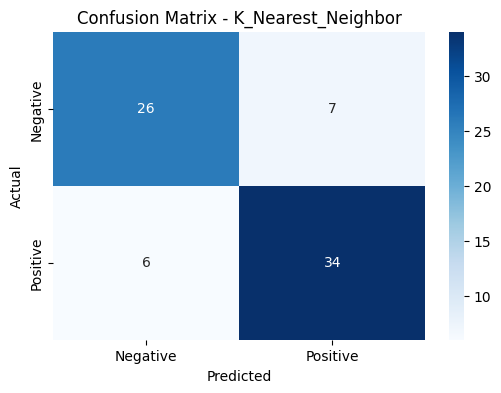

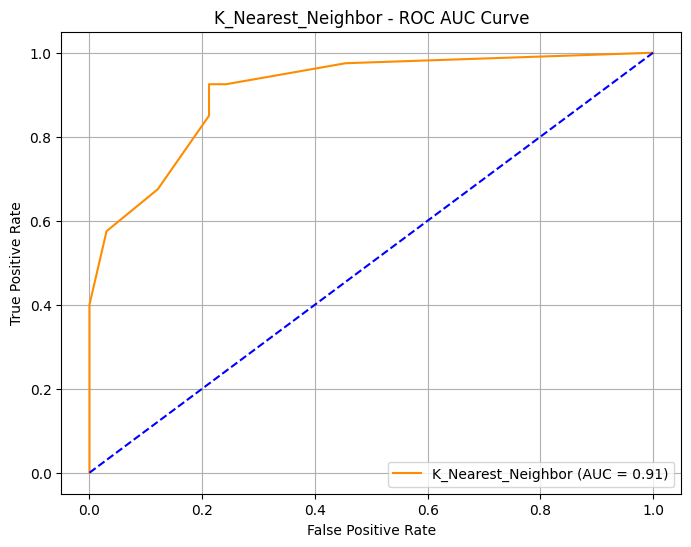

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Confusion Matrix (LSTM):
 [[24  9]
 [ 7 33]]


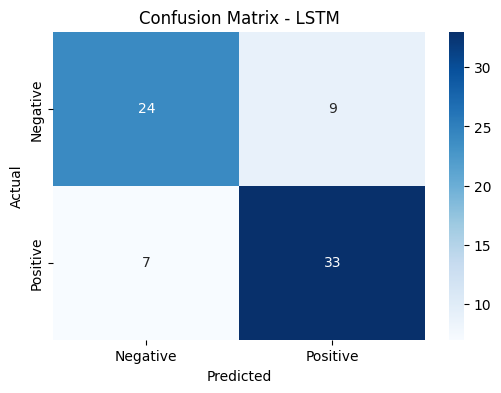

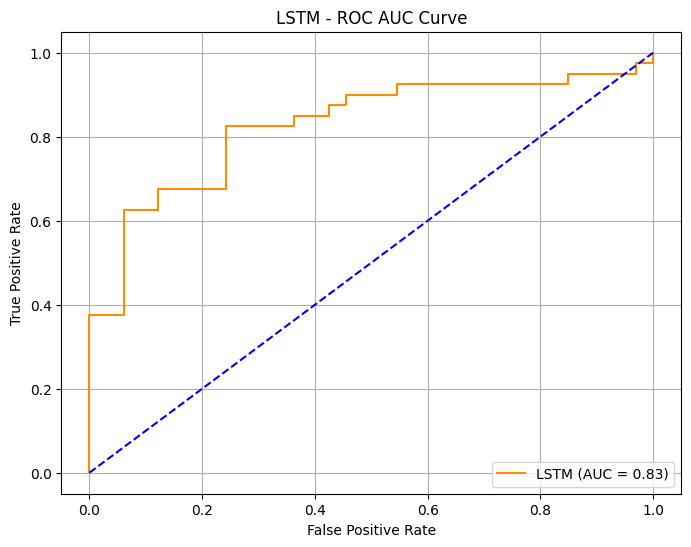


Running Fold 9

Confusion Matrix (Random_Forest):
 [[27  6]
 [ 5 35]]


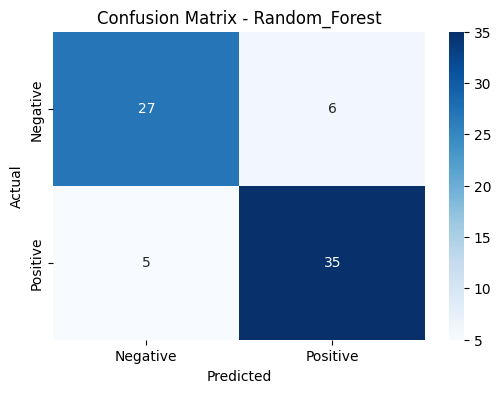

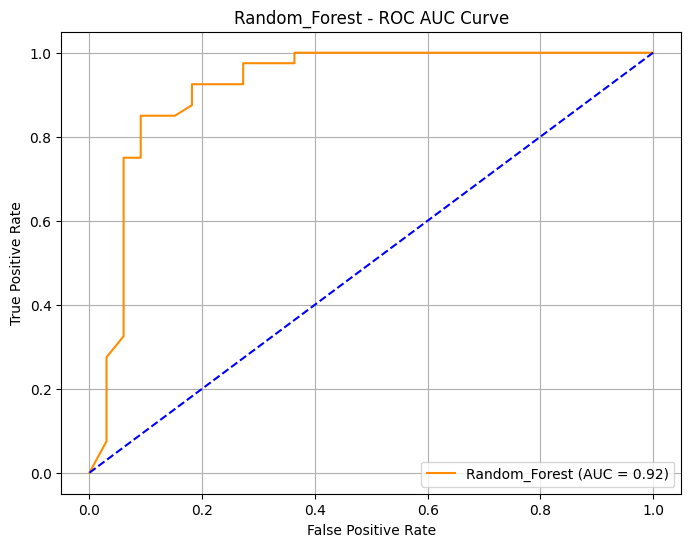


Confusion Matrix (K_Nearest_Neighbor):
 [[26  7]
 [ 3 37]]


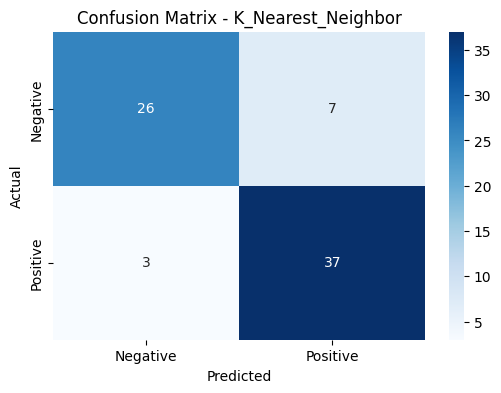

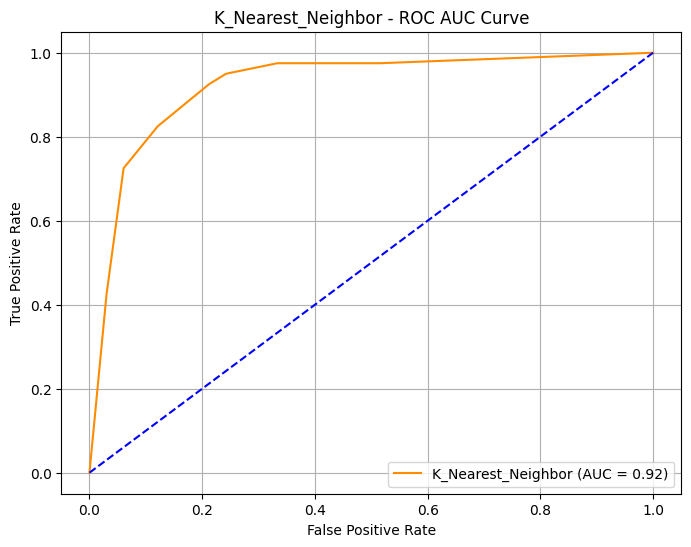

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Confusion Matrix (LSTM):
 [[18 15]
 [ 6 34]]


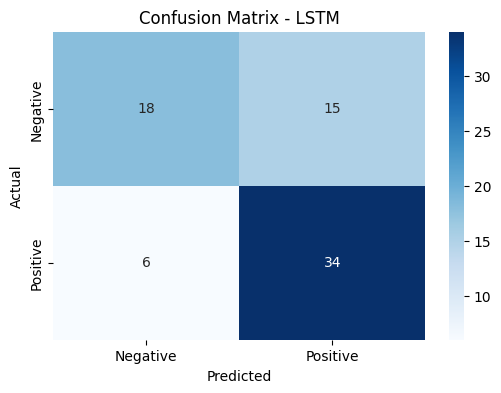

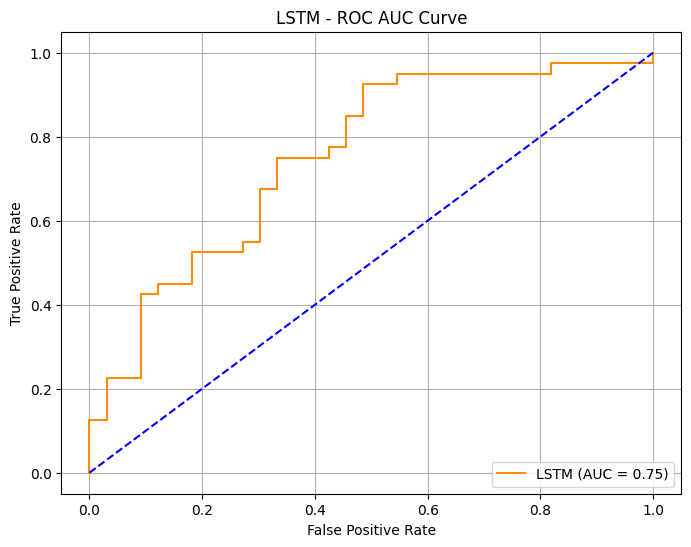


Running Fold 10

Confusion Matrix (Random_Forest):
 [[29  4]
 [ 4 36]]


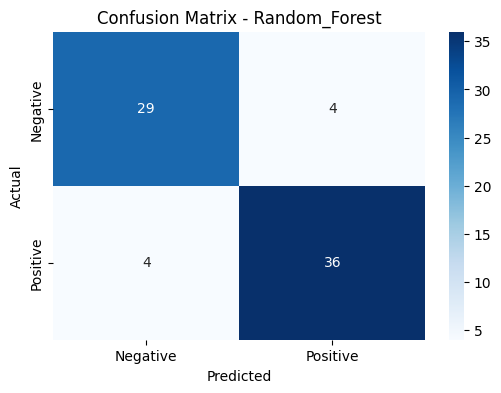

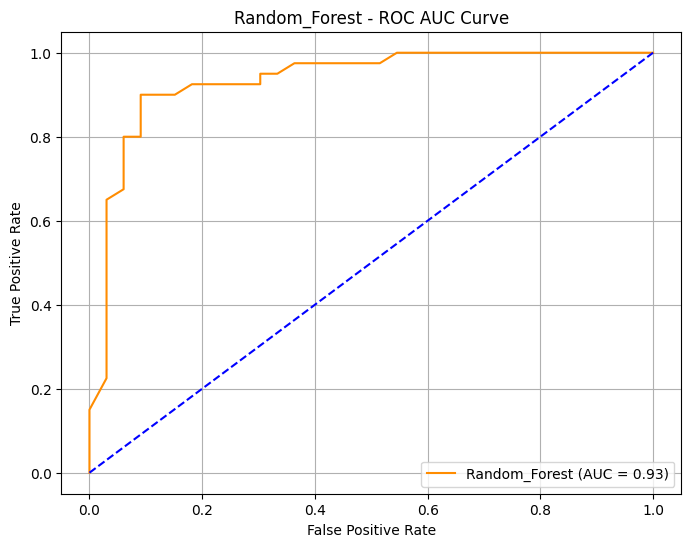


Confusion Matrix (K_Nearest_Neighbor):
 [[29  4]
 [ 7 33]]


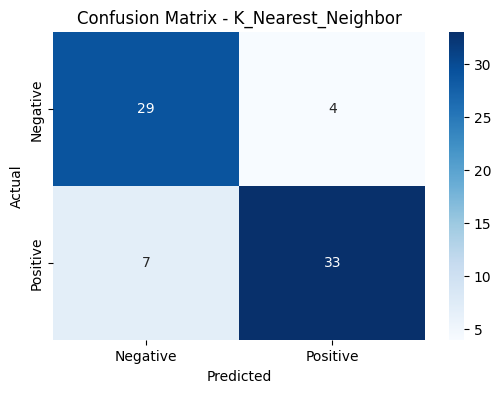

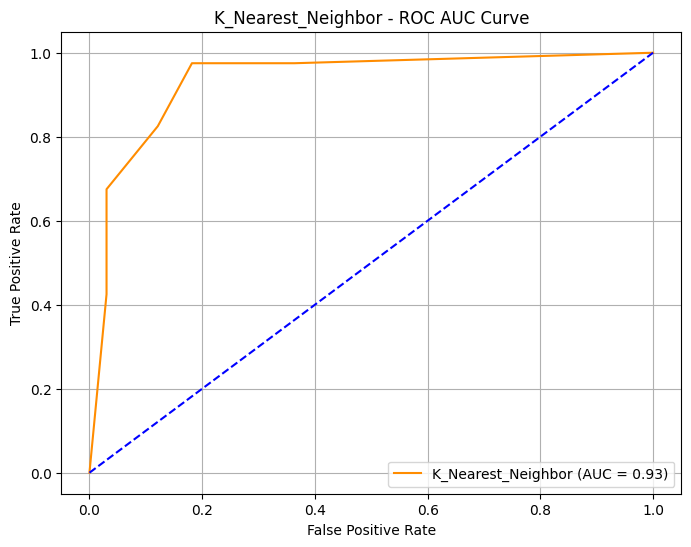

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Confusion Matrix (LSTM):
 [[18 15]
 [ 5 35]]


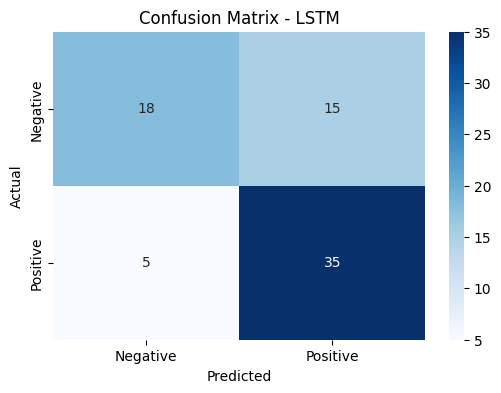

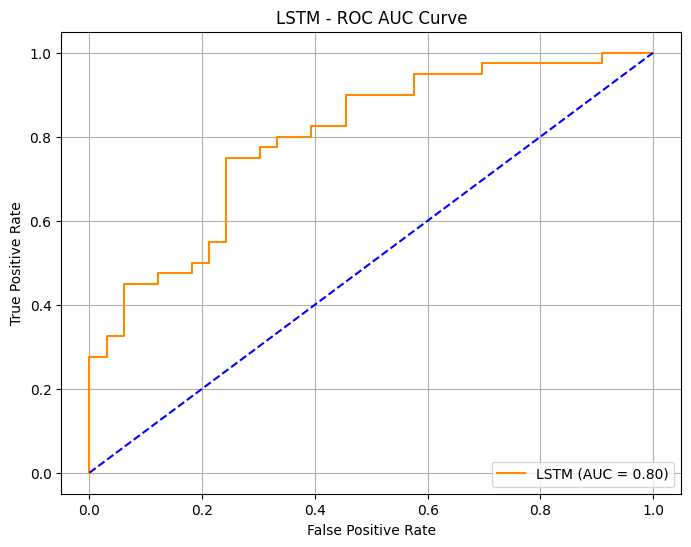

In [22]:
# Initialize Stratified K-Fold for imbalanced dataset
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for idx, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nRunning Fold {idx}")
    fold_labels.append(f"Fold_{idx}")
    
    # Fold-specific splits
    X_train_fold = X_train.iloc[train_idx]
    X_test_fold = X_train.iloc[test_idx]
    y_train_fold = y_train.iloc[train_idx]
    y_test_fold = y_train.iloc[test_idx]

    # Scaling features
    fold_scaler = StandardScaler()
    X_train_fold_scaled = fold_scaler.fit_transform(X_train_fold)
    X_test_fold_scaled = fold_scaler.transform(X_test_fold)

    # LSTM reshaping
    X_train_fold_lstm = X_train_fold_scaled.reshape(-1, X_train_fold_scaled.shape[1], 1)
    X_test_fold_lstm = X_test_fold_scaled.reshape(-1, X_test_fold_scaled.shape[1], 1)

    # Train and Evaluate Models
    run_random_forest("Random_Forest", rf_train_metrics, X_train_fold_scaled, y_train_fold, X_test_fold_scaled, y_test_fold)
    run_knn("K_Nearest_Neighbor", knn_train_metrics, X_train_fold_scaled, y_train_fold, X_test_fold_scaled, y_test_fold)
    run_lstm("LSTM", lstm_train_metrics, X_train_fold_lstm, y_train_fold, X_test_fold_lstm, y_test_fold)


In [23]:
# Convert training fold results to DataFrames
rf_df = pd.DataFrame(rf_train_metrics).T
rf_df.columns = fold_labels

knn_df = pd.DataFrame(knn_train_metrics).T
knn_df.columns = fold_labels

lstm_df = pd.DataFrame(lstm_train_metrics).T
lstm_df.columns = fold_labels

In [24]:
# Display per-fold metrics
print("\nRandom Forest - KFold Training Metrics:")
print(rf_df)
print("\nK-Nearest Neighbors - KFold Training Metrics:")
print(knn_df)
print("\nLSTM - KFold Training Metrics:")
print(lstm_df)


Random Forest - KFold Training Metrics:
                                Fold_1     Fold_2     Fold_3     Fold_4  \
True Positive (TP)           33.000000  38.000000  34.000000  36.000000   
True Negative (TN)           30.000000  29.000000  29.000000  24.000000   
False Positive (FP)           4.000000   5.000000   5.000000   9.000000   
False Negative (FN)           7.000000   2.000000   6.000000   5.000000   
Sensitivity (TPR)             0.825000   0.950000   0.850000   0.878049   
Specificity (TNR)             0.882353   0.852941   0.852941   0.727273   
False Positive Rate (FPR)     0.117647   0.147059   0.147059   0.272727   
False Negative Rate (FNR)     0.175000   0.050000   0.150000   0.121951   
Recall (r)                    0.825000   0.950000   0.850000   0.878049   
Precision (P)                 0.891892   0.883721   0.871795   0.800000   
F1 Measure (F1)               0.857143   0.915663   0.860759   0.837209   
Accuracy                      0.851351   0.905405   0.85135

In [25]:
# Compute Average Performance per Algorithm
rf_avg = rf_df.mean(axis=1)
knn_avg = knn_df.mean(axis=1)
lstm_avg = lstm_df.mean(axis=1)

average_summary = pd.DataFrame({
    "Random Forest": rf_avg,
    "K-Nearest Neighbor": knn_avg,
    "LSTM": lstm_avg
})

print("\nAverage Cross-Validation Performance Metrics:")
print(average_summary)


Average Cross-Validation Performance Metrics:
                             Random Forest  K-Nearest Neighbor       LSTM
True Positive (TP)               35.300000           35.700000  32.800000
True Negative (TN)               27.800000           27.400000  22.600000
False Positive (FP)               5.500000            5.900000  10.700000
False Negative (FN)               4.800000            4.400000   7.300000
Sensitivity (TPR)                 0.880305            0.890244   0.817988
Specificity (TNR)                 0.834581            0.822727   0.679144
False Positive Rate (FPR)         0.165419            0.177273   0.320856
False Negative Rate (FNR)         0.119695            0.109756   0.182012
Recall (r)                        0.880305            0.890244   0.817988
Precision (P)                     0.865888            0.859546   0.772456
F1 Measure (F1)                   0.872569            0.873719   0.783173
Accuracy                          0.859700            0.859663   

In [26]:
# Scale the full training and test sets
final_scaler = StandardScaler()
X_train_final = final_scaler.fit_transform(X_train)
X_test_final = final_scaler.transform(X_test)

In [27]:
# Reshape for LSTM input
X_train_final_lstm = X_train_final.reshape(-1, X_train_final.shape[1], 1)
X_test_final_lstm = X_test_final.reshape(-1, X_test_final.shape[1], 1)

In [28]:
# Lists to store final test results
rf_test_metrics, knn_test_metrics, lstm_test_metrics = [], [], []


Confusion Matrix (Random_Forest_Test):
 [[66 11]
 [11 96]]


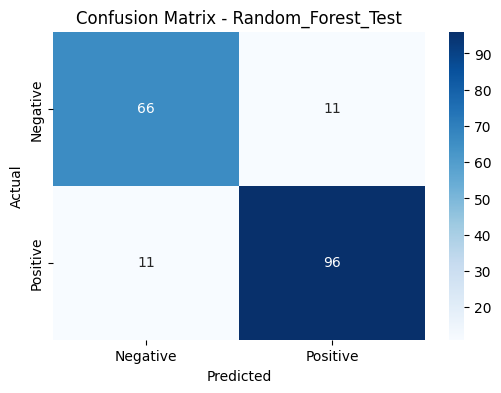

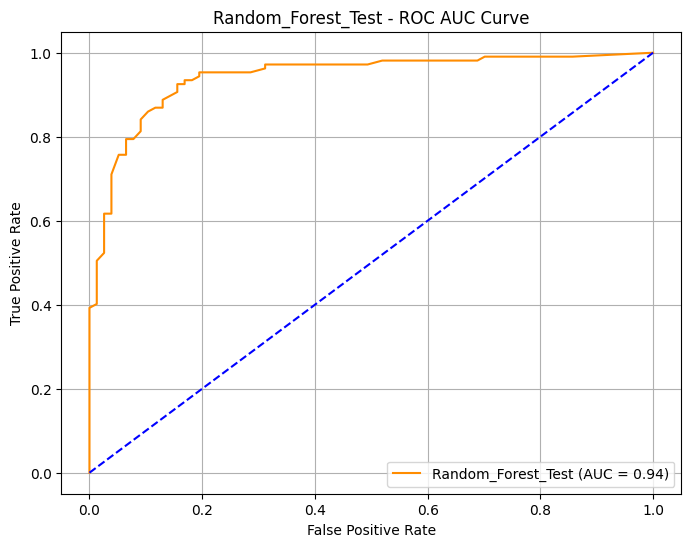


Confusion Matrix (K_Nearest_Neighbor_Test):
 [[67 10]
 [18 89]]


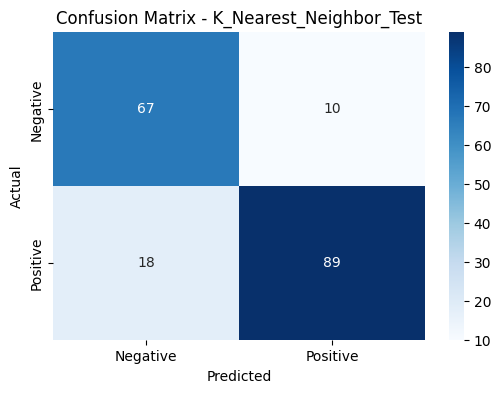

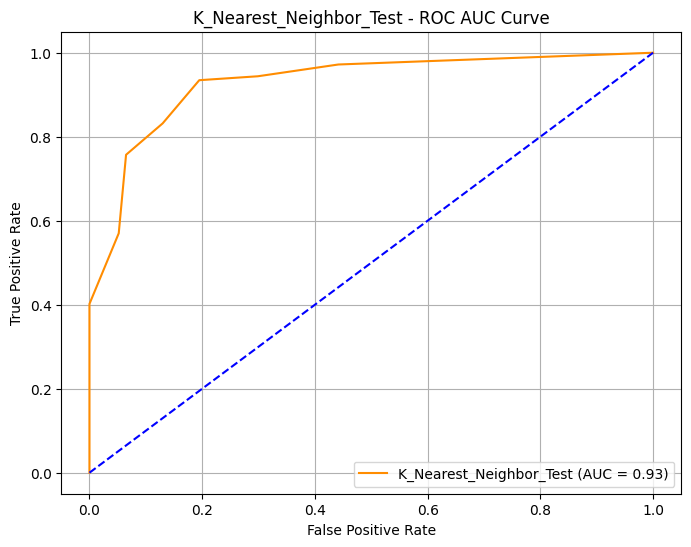

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Confusion Matrix (LSTM_Test):
 [[54 23]
 [19 88]]


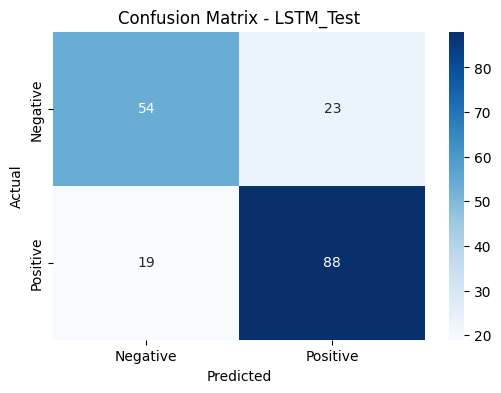

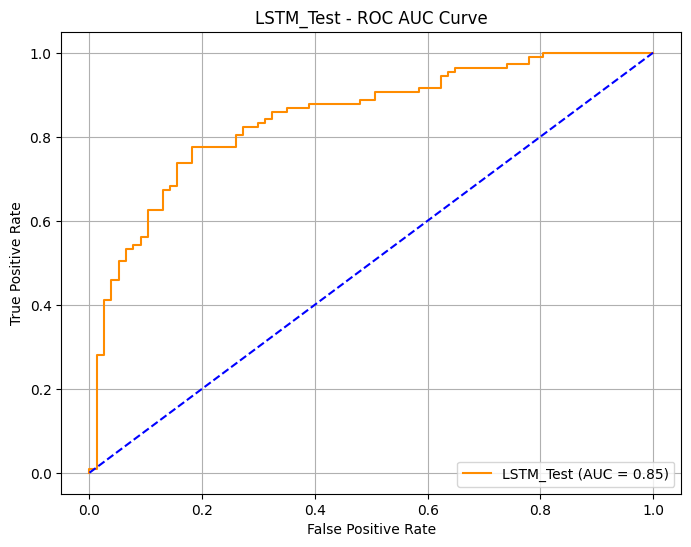

[{'True Positive (TP)': np.int64(88),
  'True Negative (TN)': np.int64(54),
  'False Positive (FP)': np.int64(23),
  'False Negative (FN)': np.int64(19),
  'Sensitivity (TPR)': np.float64(0.822429906542056),
  'Specificity (TNR)': np.float64(0.7012987012987013),
  'False Positive Rate (FPR)': np.float64(0.2987012987012987),
  'False Negative Rate (FNR)': np.float64(0.17757009345794392),
  'Recall (r)': np.float64(0.822429906542056),
  'Precision (P)': np.float64(0.7927927927927928),
  'F1 Measure (F1)': np.float64(0.8073394495412844),
  'Accuracy': np.float64(0.7717391304347826),
  'Error Rate': np.float64(0.22826086956521738),
  'Balanced Accuracy': np.float64(0.7618643039203787),
  'True Skill Statistics (TSS)': np.float64(0.5237286078407574),
  'Heidke Skill Score (HSS)': np.float64(0.5275706076537474),
  'ROC_AUC Score': np.float64(0.8458550794999393),
  'Brier Score': np.float64(0.15845459188131197),
  'Brier Skill Score': np.float64(0.3521710647564258)}]

In [29]:
# Final model evaluations on unseen test set
run_random_forest("Random_Forest_Test", rf_test_metrics, X_train_final, y_train, X_test_final, y_test)
run_knn("K_Nearest_Neighbor_Test", knn_test_metrics, X_train_final, y_train, X_test_final, y_test)
run_lstm("LSTM_Test", lstm_test_metrics, X_train_final_lstm, y_train, X_test_final_lstm, y_test)

In [30]:
# Convert to DataFrames
rf_test_df = pd.DataFrame(rf_test_metrics).T
knn_test_df = pd.DataFrame(knn_test_metrics).T
lstm_test_df = pd.DataFrame(lstm_test_metrics).T

In [31]:
# Combine Test Metrics
test_results_df = pd.concat([rf_test_df, knn_test_df, lstm_test_df], axis=1)
test_results_df.columns = ["Random Forest", "K-Nearest Neighbor", "LSTM"]

In [32]:
print("\nTest Set Performance Comparison:")
print(test_results_df)


Test Set Performance Comparison:
                             Random Forest  K-Nearest Neighbor       LSTM
True Positive (TP)               96.000000           89.000000  88.000000
True Negative (TN)               66.000000           67.000000  54.000000
False Positive (FP)              11.000000           10.000000  23.000000
False Negative (FN)              11.000000           18.000000  19.000000
Sensitivity (TPR)                 0.897196            0.831776   0.822430
Specificity (TNR)                 0.857143            0.870130   0.701299
False Positive Rate (FPR)         0.142857            0.129870   0.298701
False Negative Rate (FNR)         0.102804            0.168224   0.177570
Recall (r)                        0.897196            0.831776   0.822430
Precision (P)                     0.897196            0.898990   0.792793
F1 Measure (F1)                   0.897196            0.864078   0.807339
Accuracy                          0.880435            0.847826   0.771739
Erro

In [33]:
# Identify Best Performing Algorithm on Test Accuracy
test_accuracy_scores = {
    "Random Forest": rf_test_metrics[0]["Accuracy"],
    "K-Nearest Neighbor": knn_test_metrics[0]["Accuracy"],
    "LSTM": lstm_test_metrics[0]["Accuracy"]
}
best_test_model = max(test_accuracy_scores, key=test_accuracy_scores.get)
print(f"\nBest Accuracy on Test Set: {best_test_model} ({test_accuracy_scores[best_test_model] * 100:.2f}%)")


Best Accuracy on Test Set: Random Forest (88.04%)


In [34]:
# Best Train Accuracy (based on average CV accuracy)
train_accuracy_scores = {
    "Random Forest": rf_avg["Accuracy"],
    "K-Nearest Neighbor": knn_avg["Accuracy"],
    "LSTM": lstm_avg["Accuracy"]
}
best_train_model = max(train_accuracy_scores, key=train_accuracy_scores.get)
print(f"Best Accuracy on Train Set: {best_train_model} ({train_accuracy_scores[best_train_model] * 100:.2f}%)")


Best Accuracy on Train Set: Random Forest (85.97%)
